$\Huge{\text{Omnical Degeneracy Removal}}$

$\mbox{ }$

$\LARGE{\text{Josh Dillon and Aaron Parsons}}$


# Overview

In investigating the strange behavior of Omnical with degeneracy removal turned on, we realized that Omnical assumed that Firstcal (FC), which fixes per-antenna delays only, had already been applied. A "good enough" Firstcal prevents antenna gains from phase-wrapping over the full bandwidth, which can lead to discontinuities in the tip and tilt degeneracy terms in Omnical. 

Zaki is now developing a fix to this problem which will live in the HERA-Team repo at https://github.com/HERA-Team/heracal

In this notebook we will recreate the problem and demonstrate the solution.

# Settings and Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aipy as a 
import capo
import capo.miriad as miriad
import capo.omni as omni
from copy import deepcopy
%matplotlib inline 

In [2]:
pol = 'yy'
xants = [81]
meta,data,flags = miriad.read_files(['zen.2457678.39660.yy.HH.uvc'],'cross',pol)
fcm,fcg,fcv,fcx = omni.from_npz('zen.2457678.39660.yy.HH.uvc.fc.npz')
fcData = deepcopy(data)
for (ant1,ant2) in fcData.keys():
    if ant1 not in xants and ant2 not in xants:
        fcData[(ant1,ant2)][pol] /= (fcg[pol[0]][ant1] * np.conj(fcg[pol[1]][ant2]))    
freqs = meta['freqs']
nint, nchan = data.values()[0].values()[0].shape
aa = a.cal.get_aa('hsa7458_v001', freqs)

# Perform Omnical

In [3]:
info = omni.aa_to_info(aa, pols=[pol[0]], ex_ants=xants, crosspols=[pol])
reds = info.get_reds()
antNames = [i for i,pos in enumerate(aa.antpos_ideal) 
            if pos[2] != -1.0 and i not in xants]
g0 = {pol[0]: {ant: np.ones((nint,nchan),dtype=complex) for ant in antNames}}

/Users/jsdillon/anaconda/lib/python2.7/site-packages/capo/omni.py:98: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  antpos[i,0], antpos[i,1], antpos[i,2] = x,y,z


## Omnical with removedgen=True on raw data with FC as a starting point
This is how we had been operating with PAPER-128 and HERA.

In [4]:
m1, g1, v1 = omni.redcal(data, info, gains=fcg, removedegen=True)
m2, g2, v2 = omni.redcal(data, info, vis=v1, gains=g1, 
                         uselogcal=False, removedegen=True)
g2[pol[0]] = {ant: g2[pol[0]][ant] / fcg[pol[0]][ant] for ant in g2[pol[0]].keys()}

## Omnical with removedgen=True on FC data

In [5]:
m1t, g1t, v1t = omni.redcal(fcData, info, gains=g0, removedegen=True)
m2t, g2t, v2t = omni.redcal(fcData, info, vis=v1t, gains=g1t, 
                            uselogcal=False, removedegen=True)

## Omnical with FC data, removing dengeracies manually

In [6]:
m1f, g1f, v1f = omni.redcal(fcData, info, gains=g0, removedegen=False)
m2f, g2f, v2f = omni.redcal(fcData, info, vis=v1f, gains=g1f, 
                            uselogcal=False, removedegen=False)

### Fit out a phase gradient, average phase, and average gain.

In [7]:
NTIMES, NCHAN, ALL_ANTS, POL = nint, nchan, antNames, pol
phsgrad = np.empty((NTIMES,3,NCHAN), np.float)
for t in xrange(NTIMES):
    gdata = np.angle([g2f[POL[0]][i][t] for i in ALL_ANTS])
    d,w = {}, {}
    for i,ai in enumerate(ALL_ANTS):
        d['%f*dphsdx+%f*dphsdy+%f*dphsdz' % tuple(aa[ai].pos)] = gdata[i]
        w['%f*dphsdx+%f*dphsdy+%f*dphsdz' % tuple(aa[ai].pos)] = 1.
    ls = capo.linsolve.LinearSolver(d,w)
    sols = ls.solve()
    phsgrad[t] = np.array([sols['dphsdx'], sols['dphsdy'], sols['dphsdz']])
    
pg = {POL[0]:{}}
apg = {POL[0]:{}}
for i in ALL_ANTS: 
    pg[POL[0]][i] = g2f[POL[0]][i] / np.exp(1j*np.dot(aa[i].pos, phsgrad))
avgphs = np.average([np.angle(pg[POL[0]][i]) for i in ALL_ANTS], axis=0)
avgamp = np.average([np.abs(pg[POL[0]][i]) for i in ALL_ANTS], axis=0)
for i in ALL_ANTS: 
    apg[POL[0]][i] = pg[POL[0]][i] / np.exp(1j*avgphs) / avgamp

# Results and Discussion

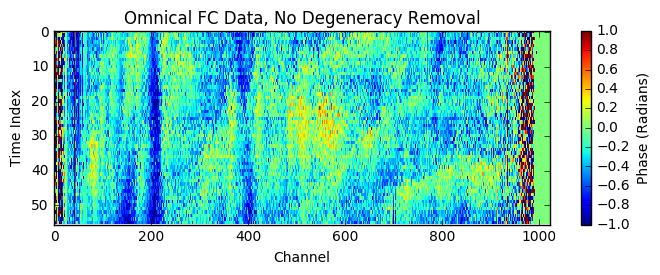

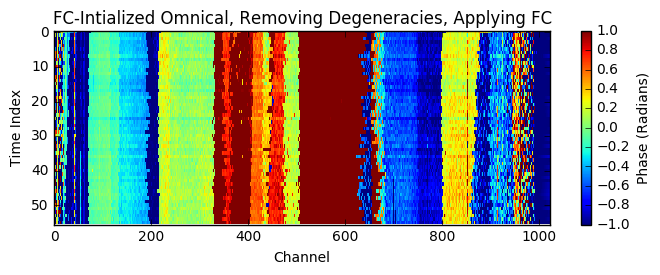

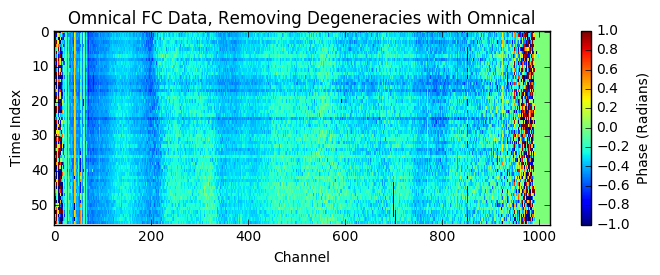

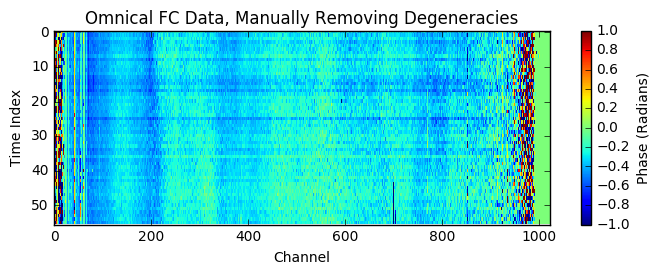

In [8]:
titles = ['Omnical FC Data, No Degeneracy Removal',
         'FC-Intialized Omnical, Removing Degeneracies, Applying FC',
         'Omnical FC Data, Removing Degeneracies with Omnical',
         'Omnical FC Data, Manually Removing Degeneracies']
for g,title in zip([g2f,g2,g2t,apg], titles):
    plt.figure(figsize=(8,2.5))
    capo.plot.waterfall(g[pol[0]][88], mode='phs',  mx=1, drng=2)
    plt.title(title); plt.xlabel('Channel'); plt.ylabel('Time Index')
    plt.colorbar(label='Phase (Radians)')

As we can see, removing degeneracies is essential. They add what looks likes extra noise into the gains and visibiltiies. However, if we merely initialize Omnical with Firstcal as a starting guess, rather than apply Firstcal to the data that goes into Omnical, the built-in degeneracy removal algorithm is vulnerable to phase-wrap discontinuities that create jumps in the gains and visibilities that can be smaller than $2\pi$ and are therefore not trivial to pick out.

If we apply Firstcal to the data before running Omnical, Omnical will properly remove the degeneracies. This has been verified by manually removing the degeneracies by fitting phase gradients gains and removing them.